  Имеются данные приложения по доставке готовых продуктов. Нужно проверить с помощью ANOVA и критерия Тьюки, какой формат фотографий блюд (A, B или C) является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента с помощью многофакторного дисперсионного анализа.
  

**Описание данных:**<br>

**5_task_1:**<br>

id – id клиента в эксперименте<br>
group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)<br>
events – сколько блюд суммарно было заказано за период<br>
**5_task_2:**<br>

id – id клиента в эксперименте<br>
segment – сегмент (high/low)<br>
group – вид кнопки (control – старая версия, test – новая версия)<br>
events – сколько блюд суммарно было заказано за период<br>

In [7]:
import pandas as pd
import scipy
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid',
       rc={'figure.figsize':(20,7)})

In [2]:
data1 = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_1.csv')
data1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [3]:
data1.groupby('group').events.mean()

group
A    29.5796
B    37.6136
C    27.4703
Name: events, dtype: float64

In [7]:
data1.groupby('group').agg({'events':'mean'})

,events
group,
A,29.5796
B,37.6136
C,27.4703


Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [18]:
scipy.stats.levene(data1[data1.group == 'A'].events, data1[data1.group == 'B'].events, data1[data1.group == 'C'].events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

p-value > 0.05, не отклоняем нулевую гипотезу - дисперсии внутри групп примерно одинаковые.

Убедимся, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделаем семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты.

In [21]:
stats.shapiro(data1[data1.group == 'A'].events.sample(1000, random_state=17))

(0.9973153471946716, 0.09609563648700714)

In [22]:
stats.shapiro(data1[data1.group == 'B'].events.sample(1000, random_state=17))

(0.9980798363685608, 0.31768906116485596)

In [23]:
stats.shapiro(data1[data1.group == 'C'].events.sample(1000, random_state=17))

(0.9981185793876648, 0.3359004259109497)

Распределения в каждой группе являются нормальными, p-value > 0.05. Проведем ANOVA test (однофакторный дисперсионный анализ) для наших групп:

In [24]:
stats.f_oneway(data1[data1.group == 'A'].events, data1[data1.group == 'B'].events, data1[data1.group == 'C'].events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

p-value < 0.05, отклоняем нулевую гипотезу - значит, хотя бы две из трех групп имеют значимые различия в средних.

Проведем попарное сравнение групп с помощью критерия Тьюки.

In [29]:
MultiComp = MultiComparison(data1.events, data1.group)
print(MultiComp.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


Различия между всеми тремя группами значимы. Итого, лучше всего выбрать группу B - у такой группы наибольшее среднее значение events

In [5]:
data2 = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_2.csv')
data2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


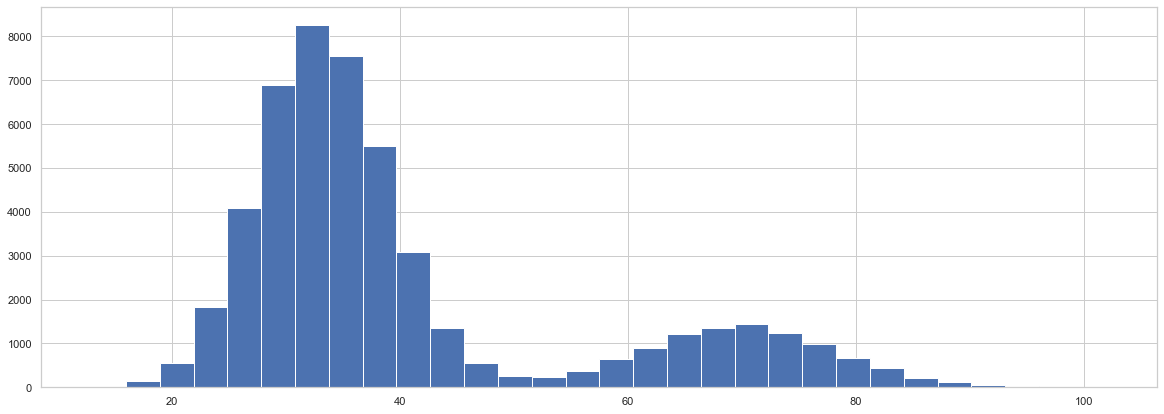

In [13]:
# Визуализируем распределение events для контрольной и тестовой групп

data2[data2.group =='test'].events.hist(bins=30)

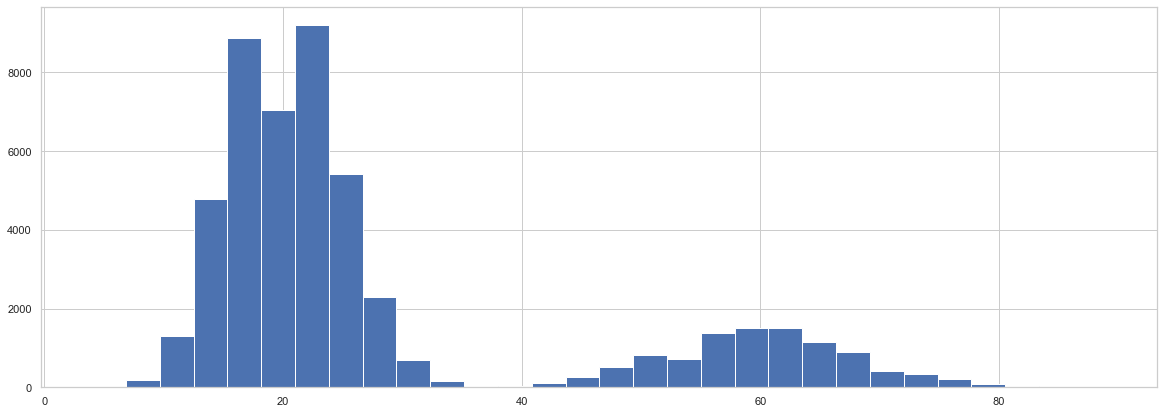

In [14]:
data2[data2.group =='control'].events.hist(bins=30)

In [15]:
# Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя.

data2.groupby(['group','segment']).agg({'events':['mean','median','std']})

events                 
                      mean median       std
group   segment                            
control high     59.970800   60.0  7.805347
        low      20.031575   20.0  4.473576
test    high     69.938500   70.0  8.403974
        low      33.025925   33.0  5.720845

Проведем многофакторный дисперсионный анализ (мы хотим проверить эффект нескольких переменных – group и segment на events, с взаимодействием факторов)

In [16]:
formula = 'events ~ segment + group + segment:group'
model = ols(formula, data2).fit()
aov_table = anova_lm(model, typ=2)

In [17]:
aov_table

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377485,0.000000e+00
group,3.837195e+06,1.0,112031.864120,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


 Значим как эффект обоих факторов, так и их взаимодействие (p-value < 0.05). 

In [51]:
data2['combination'] = data2.group + ' / ' + data2.segment
data2

,id,group,segment,events,combination
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high
3,50399,test,high,80.0,test / high
4,95613,test,high,78.0,test / high
...,...,...,...,...,...
99995,60695,control,low,15.0,control / low
99996,5934,control,low,16.0,control / low
99997,30046,control,low,22.0,control / low
99998,26474,control,low,21.0,control / low


Используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

In [52]:
MultiComp = MultiComparison(data2.events, data2.combination)
print(MultiComp.tukeyhsd().summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2    meandiff p-adj  lower    upper   reject
--------------------------------------------------------------------
control / high control / low -39.9392 0.001 -40.1073 -39.7711   True
control / high   test / high   9.9677 0.001   9.7551  10.1803   True
control / high    test / low -26.9449 0.001  -27.113 -26.7768   True
 control / low   test / high  49.9069 0.001  49.7388   50.075   True
 control / low    test / low  12.9944 0.001   12.888  13.1007   True
   test / high    test / low -36.9126 0.001 -37.0807 -36.7445   True
--------------------------------------------------------------------


Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой.
Фактор group оказался значимым, фактор segment – значимым, их взаимодействие – значимо. Судя по графику, для всех групп среднее значение events увеличилось, поэтому можно принимать изменения кнопки.

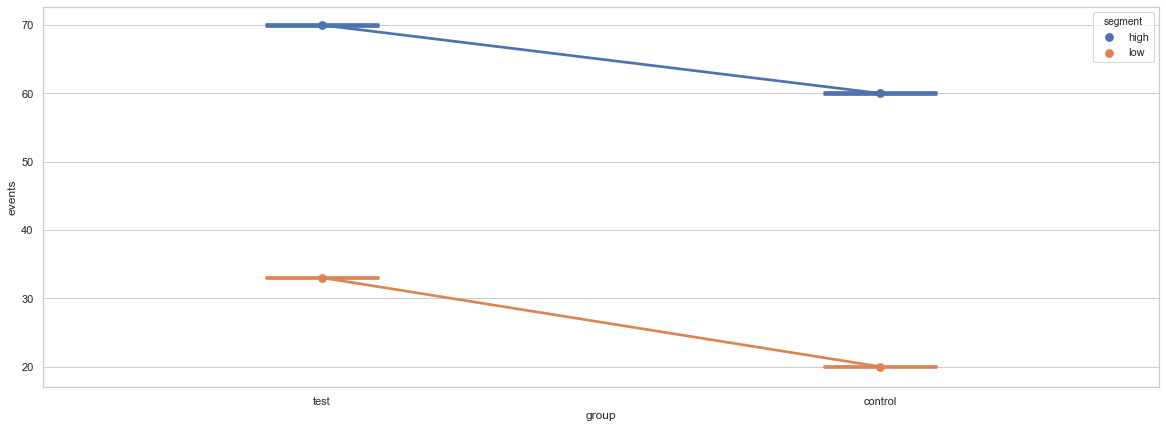

In [18]:
sns.pointplot(data = data2, x='group',y='events',hue='segment', capsize = .2)

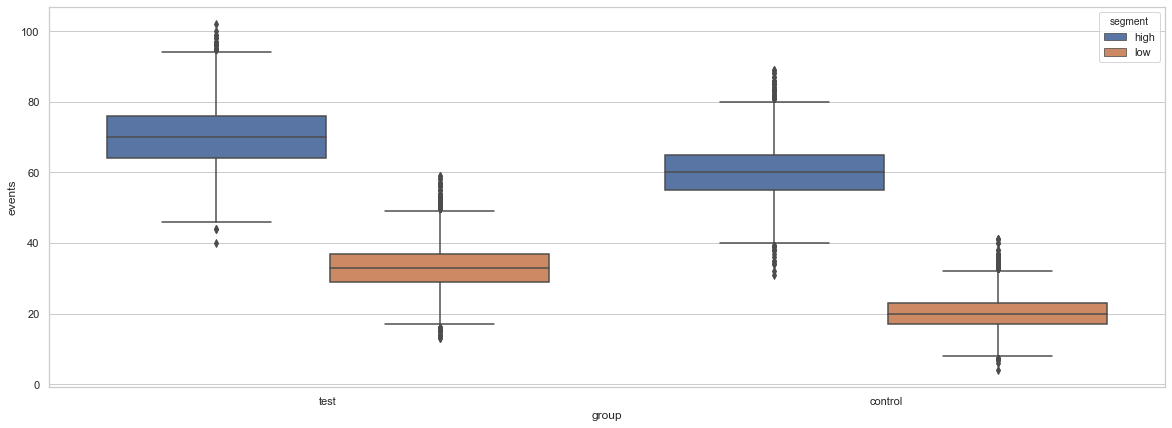

In [19]:
sns.boxplot(data = data2, x='group', y='events', hue='segment')